In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import time
import threading
from collections import Counter
import json
from pydub import AudioSegment
from pydub.playback import play

In [11]:
def plot_spectrogram(DB, sr, title):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_marked_spectogram(y_coords, x_coords, y, title):
    plt.figure(figsize=(12, 6))  # Increased figure size
    plt.imshow(y, cmap='gray', interpolation='none', aspect='auto')  # Set aspect ratio to 'auto'
    plt.scatter(x_coords, y_coords, color='red', marker='o', s=10)
    plt.title(title)
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis()
    plt.show()

def plot_hist(counter, title):
    labels, values = zip(*counter.items())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue')
    plt.xlabel('Items')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

In [12]:
args_heuristic = [2000, 100, 20]
tolerance_heuristic = [5,2]
args_local_maximum = [69]
tolerance_maximum = [5,5]
args_find_maxims = [5]
tolerance_maxims = [10,10]

In [13]:
def find_local_maxima(matrix, neighborhood_size):
    if neighborhood_size % 2 == 0:
        raise ValueError("Neighborhood size must be odd.")
    
    pad_size = neighborhood_size // 2
    y_cords = []
    x_cords = []

    for i in range(pad_size, matrix.shape[0] - pad_size):
        for j in range(pad_size, matrix.shape[1] - pad_size):
            neighborhood = matrix[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            center_value = matrix[i, j]
            
            temp = neighborhood[neighborhood != center_value]
            if len(temp) != 0 and center_value > np.max(temp):
                y_cords.append(i)
                x_cords.append(j)
    
    return y_cords, x_cords

def find_maxims(matrix, chunk_size):
    y_cords = list(np.argmax(matrix, axis=0))
    x_cords = list(range(len(y_cords)))
    y_rez, x_rez = [], []
    for i in range(0, len(y_cords), chunk_size):
        chunk = y_cords[i:i + chunk_size]
        max_index = np.argmax(chunk)
        global_max_index = i + max_index
        y_rez.append(int(y_cords[global_max_index]))
        x_rez.append(int(x_cords[global_max_index]))

    return y_rez, x_rez

def find_local_maxima_heuristic(matrix, population_size, num_iterations, neighborhood_size):
    m, n = matrix.shape
    y_coords = np.random.uniform(neighborhood_size, m, population_size).astype(int)
    x_coords = np.random.uniform(neighborhood_size, n, population_size).astype(int)
    y_rez = []
    x_rez = []
    matrix = np.pad(matrix, pad_width=neighborhood_size, mode='constant', constant_values=-np.inf)
    for y, x in zip(y_coords, x_coords):
        for _ in range(num_iterations):
            okolina = matrix[y-neighborhood_size:y+neighborhood_size + 1 , x-neighborhood_size:x+neighborhood_size + 1]
            if okolina.size == 0:
                break
            max_index = np.argmax(okolina)
            dim = (2*neighborhood_size + 1)
            if(max_index // dim == neighborhood_size and max_index % dim == neighborhood_size):
                break
            y = y + max_index // dim - neighborhood_size
            x = x + max_index % dim - neighborhood_size

        if(y - neighborhood_size not in y_rez or x - neighborhood_size not in x_rez):
            y_rez.append(int(y - neighborhood_size))
            x_rez.append(int(x - neighborhood_size))
    
    return y_rez, x_rez

In [14]:
def evaluate_similarity_hist(x_original, y_original, x_test, y_test, tolerance_y, tolerance_x):
    hist = []
    for i in range(len(x_original)):
        for j in range(len(x_test)):
            if(abs(y_original[i] - y_test[j]) < tolerance_y):
                hist.append(x_original[i] - x_test[j])

    hist = Counter(hist)
    print(hist.most_common(3))
    return hist

def evaluate_similarity(x_original, y_original, x_test, y_test, tolerance_y, tolerance_x):
    hist = []
    for i in range(len(x_original)):
        for j in range(len(x_test)):
            if(abs(y_original[i] - y_test[j]) < tolerance_y):
                hist.append(x_original[i] - x_test[j])

    hist = Counter(hist)
    if(len(hist) == 0):
        return 0
    time, nums = hist.most_common(1)[0]
    rez = nums
    for i in range(1, tolerance_x):
        if(time - i > 0):
            rez += hist[time - i]
        if(time + i < len(hist)):
            rez += hist[time + i]

    return rez

In [15]:
def test_fingerprinting(original, positive_test, negative_test, f, args):
    y_original, x_original = f(original, *args)
    plot_marked_spectogram(y_original, x_original, original, "Originalni zvijezde")
    y_test_positive, x_test_positive = f(positive_test, *args)
    plot_marked_spectogram(y_test_positive, x_test_positive, positive_test, "Odgovarajuci testni zvijezde")
    y_test_negative, x_test_negative = f(negative_test, *args)
    plot_marked_spectogram(y_test_negative, x_test_negative, negative_test, "Ne odgovarajuci testni zvijezde")
    hist = evaluate_similarity_hist(x_original, y_original, x_test_positive, y_test_positive, tolerance_x=25, tolerance_y=25)
    plot_hist(hist, "Odgovarajuci hist")
    hist = evaluate_similarity_hist(x_original, y_original, x_test_negative, y_test_negative, tolerance_x=25, tolerance_y=25)
    plot_hist(hist, "Ne odgovarajuci hist")

In [16]:
original, original_sr = librosa.load('audio_files/Aca Lukas - Bele ruze - (Audio 2000).mp3')
original = np.abs(librosa.stft(original))
positive_test, positive_test_sr = librosa.load('Bjele Ruze.mp3')
positive_test = np.abs(librosa.stft(positive_test))
negative_test, negative_test_sr = librosa.load('Pesma od bola.mp3')
negative_test = np.abs(librosa.stft(negative_test))

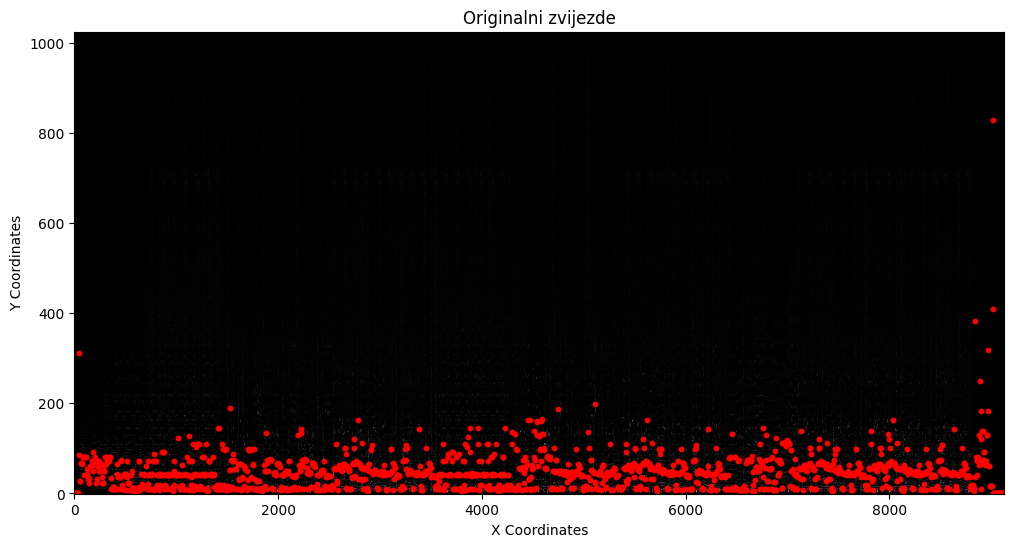

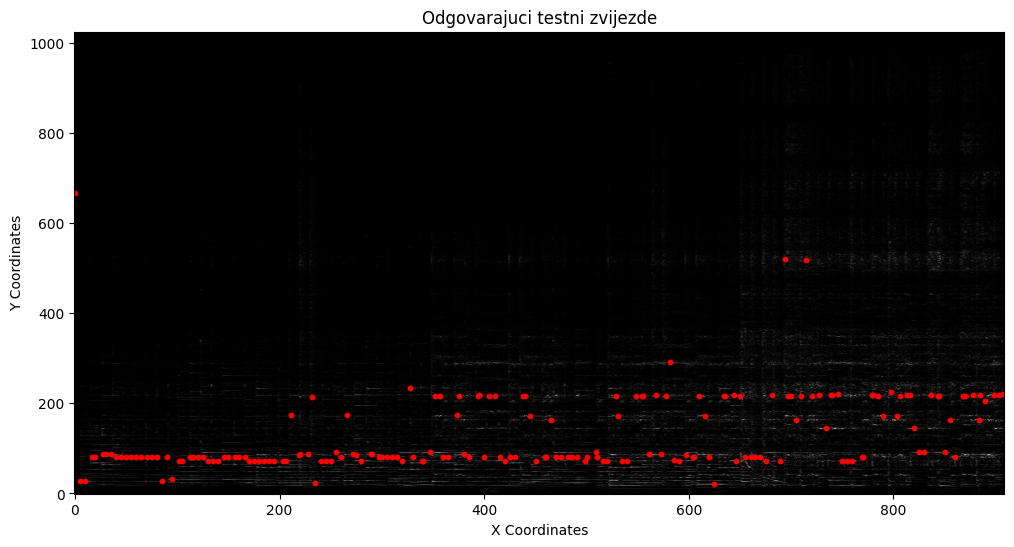

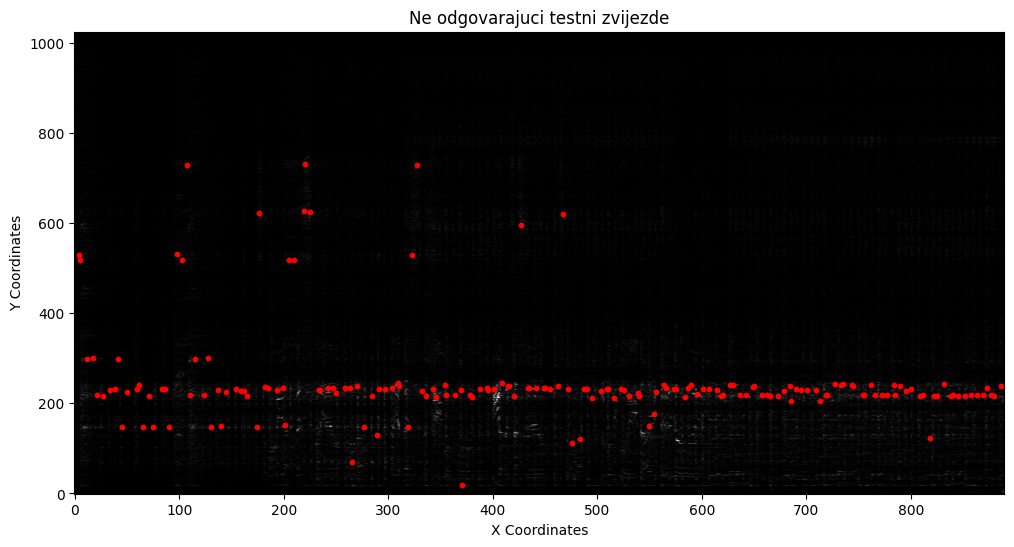

[(45, 31), (40, 25), (6575, 24)]


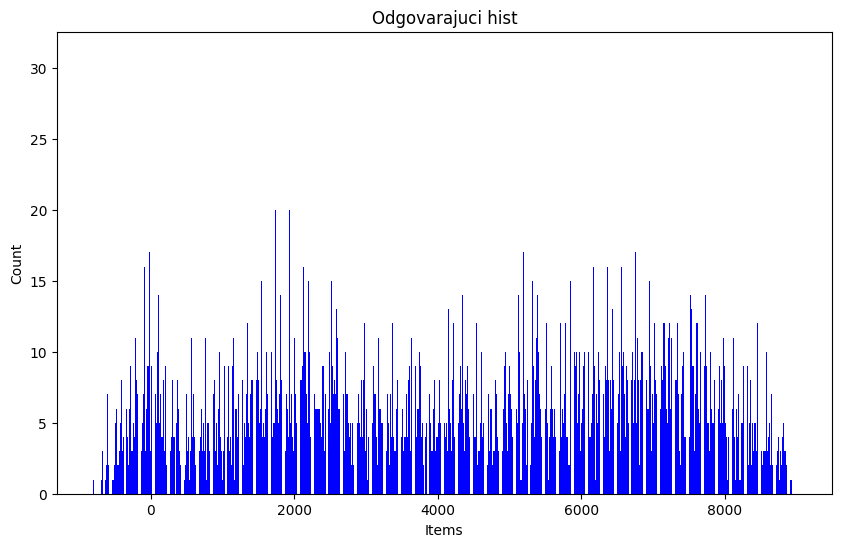

[(865, 3), (1370, 3), (1285, 3)]


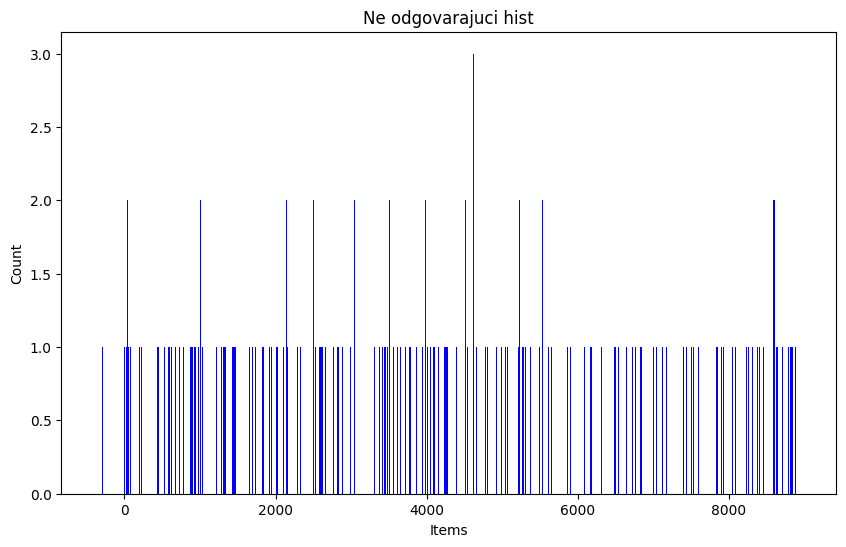

In [17]:
test_fingerprinting(original, positive_test, negative_test, find_maxims, args_find_maxims)

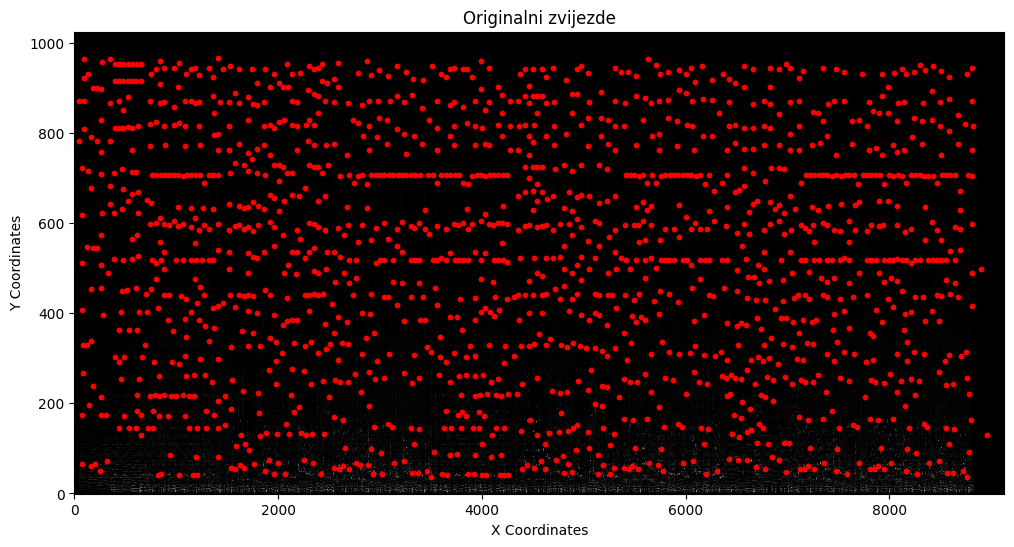

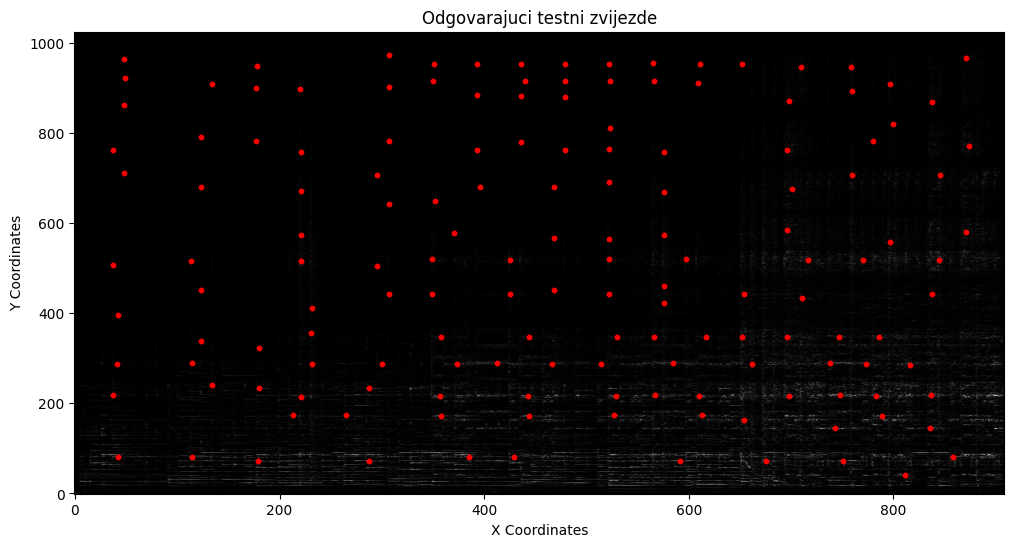

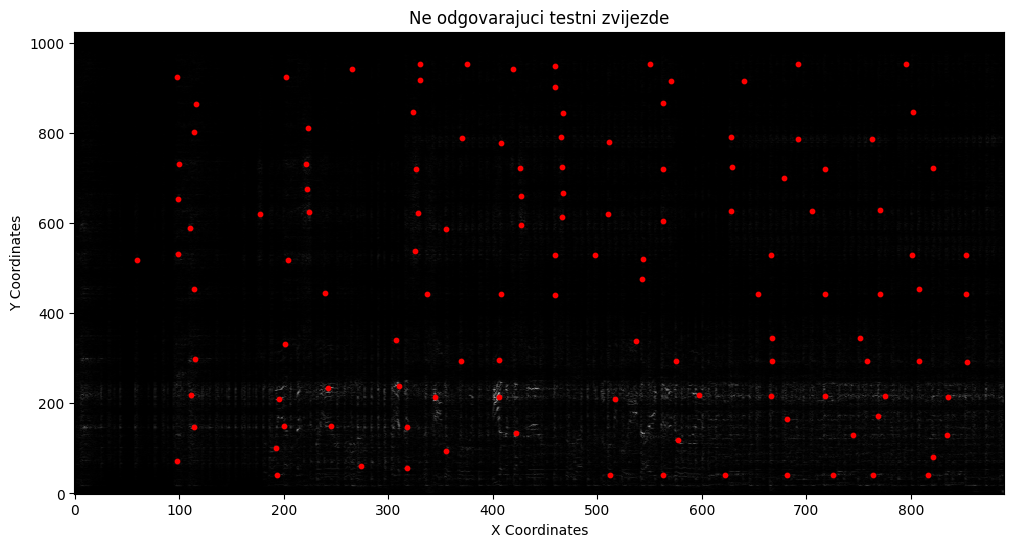

[(44, 44), (43, 19), (1, 18)]


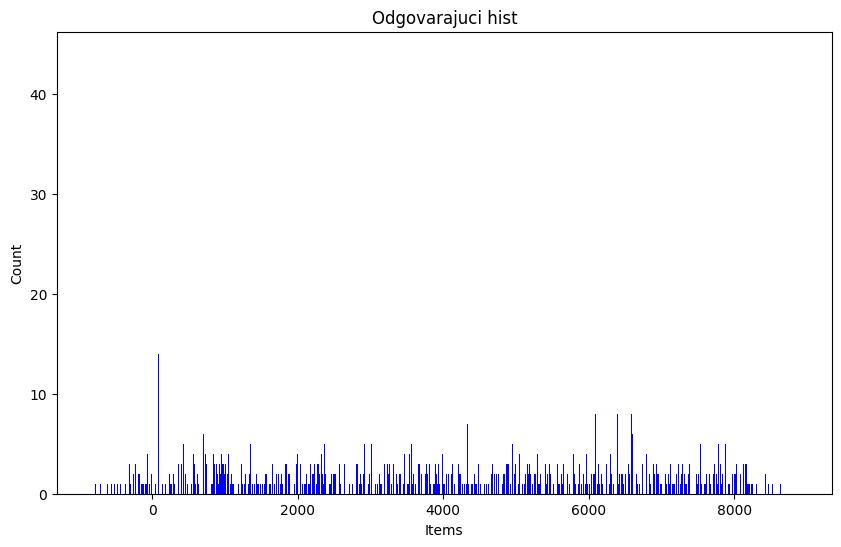

[(2707, 8), (4516, 7), (215, 7)]


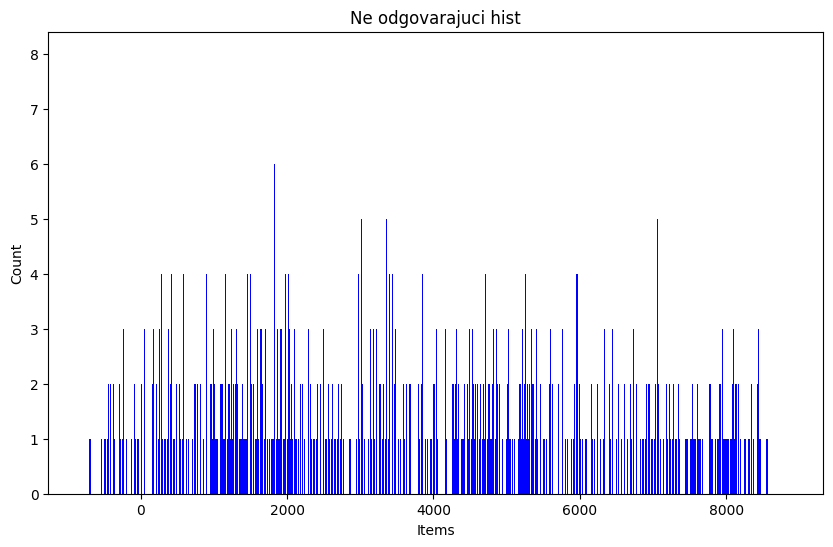

In [18]:
test_fingerprinting(original, positive_test, negative_test, find_local_maxima, args_local_maximum)

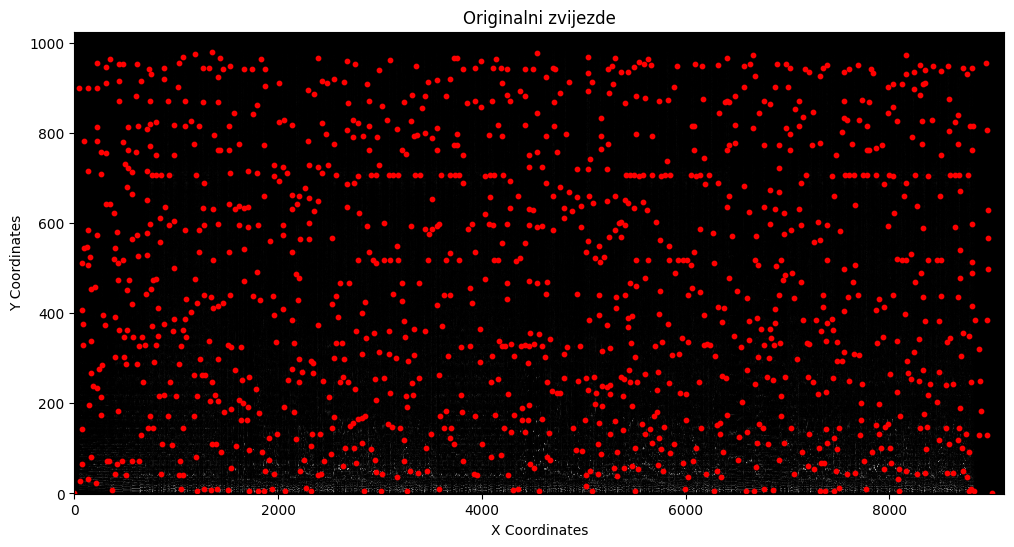

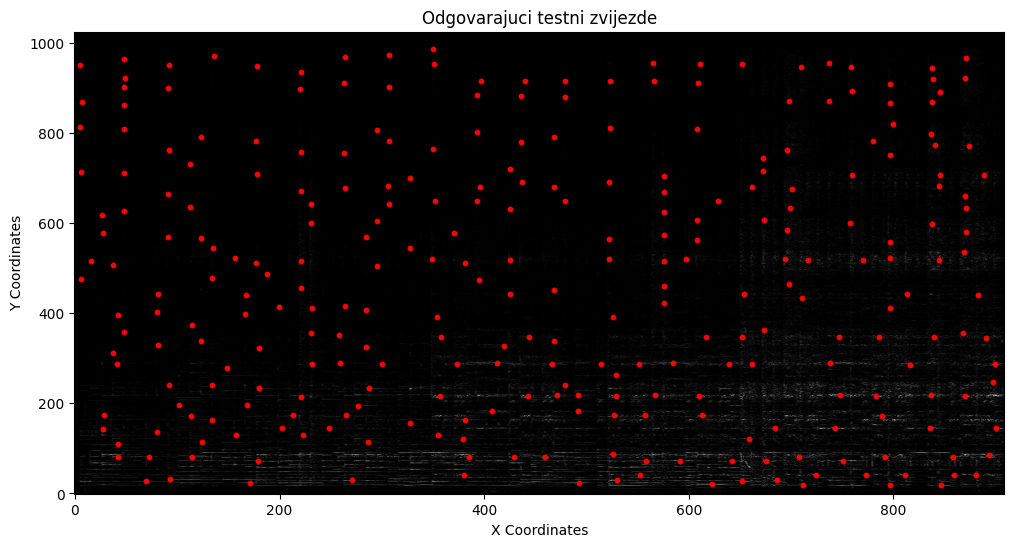

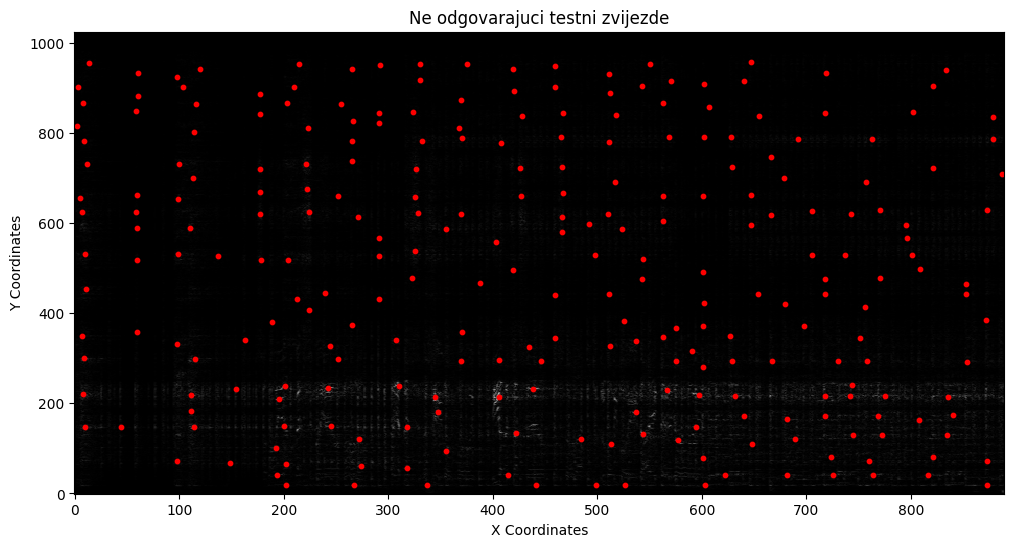

[(44, 40), (130, 17), (216, 16)]


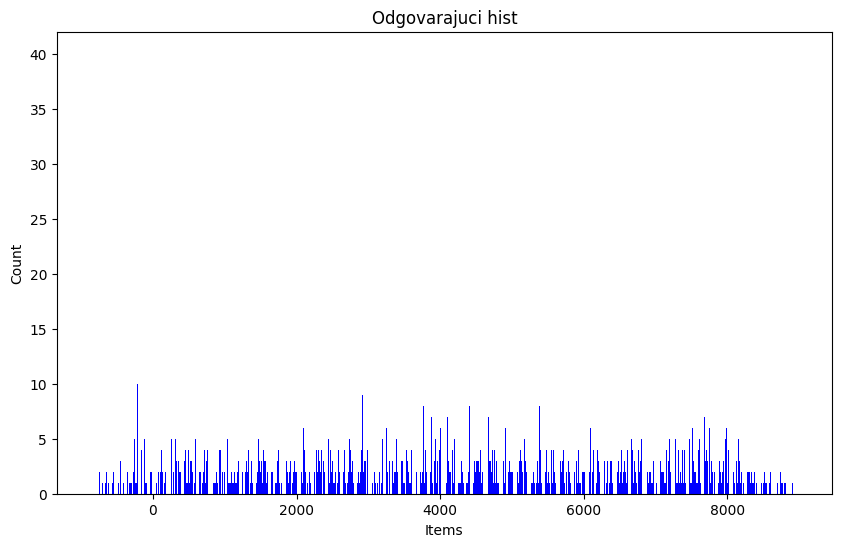

[(3797, 8), (5459, 8), (35, 8)]


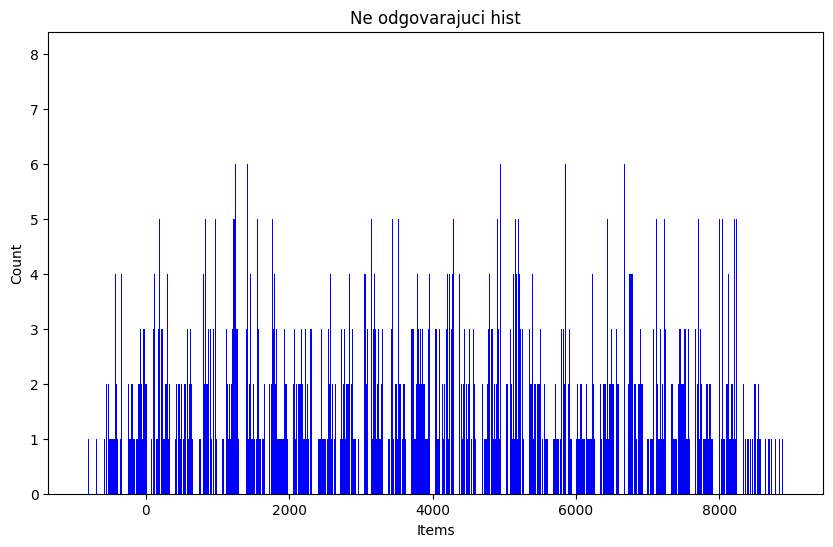

In [ ]:
test_fingerprinting(original, positive_test, negative_test, find_local_maxima_heuristic, args_heuristic)

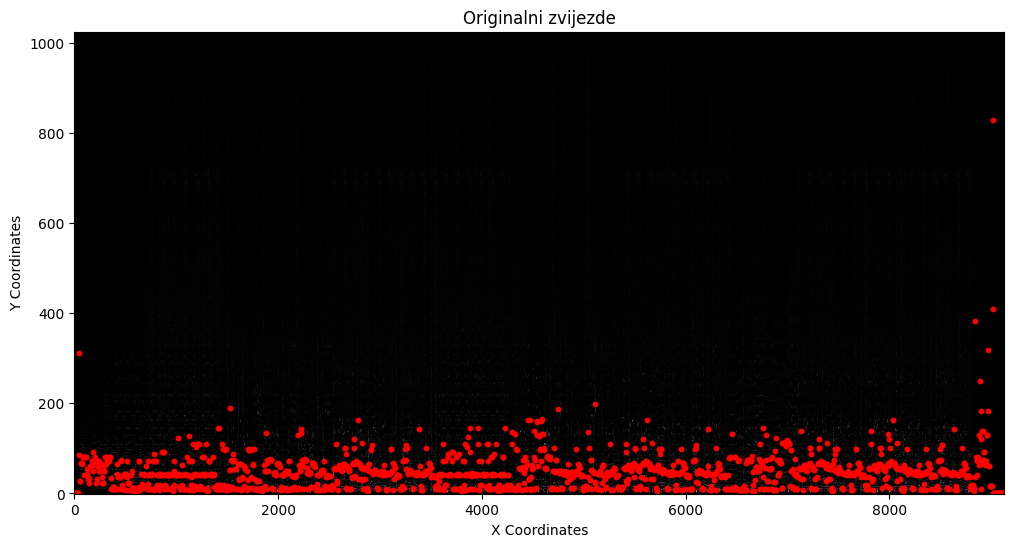

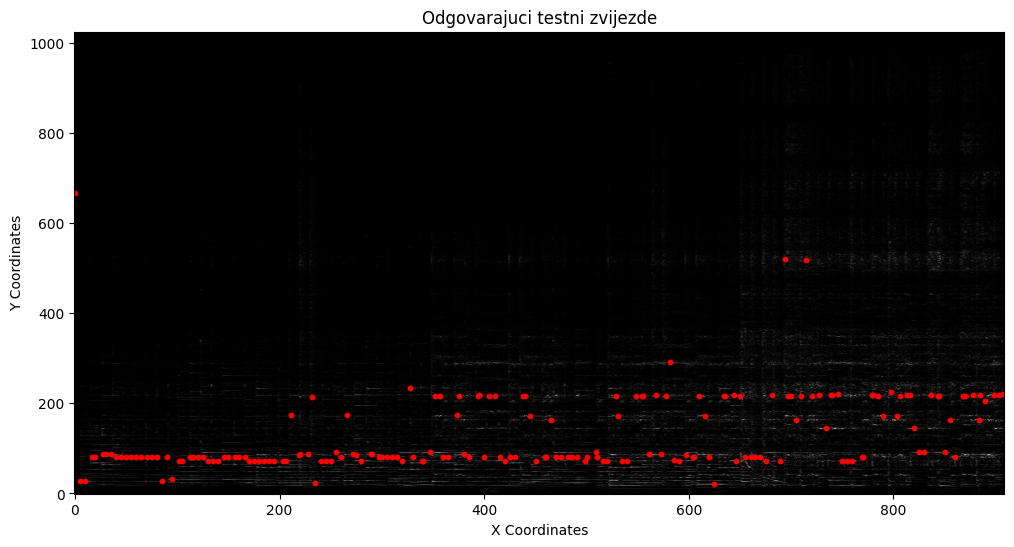

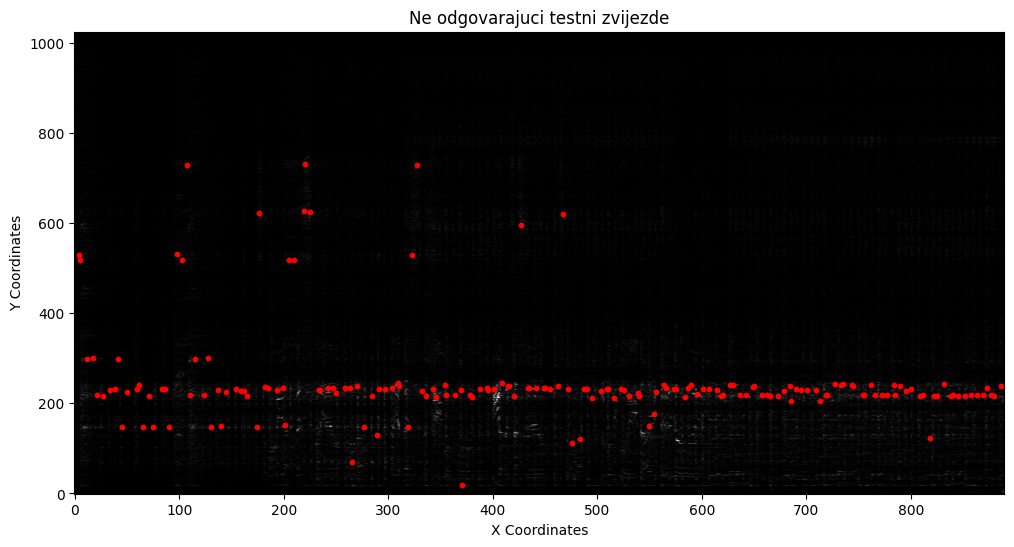

[(45, 31), (40, 25), (6575, 24)]


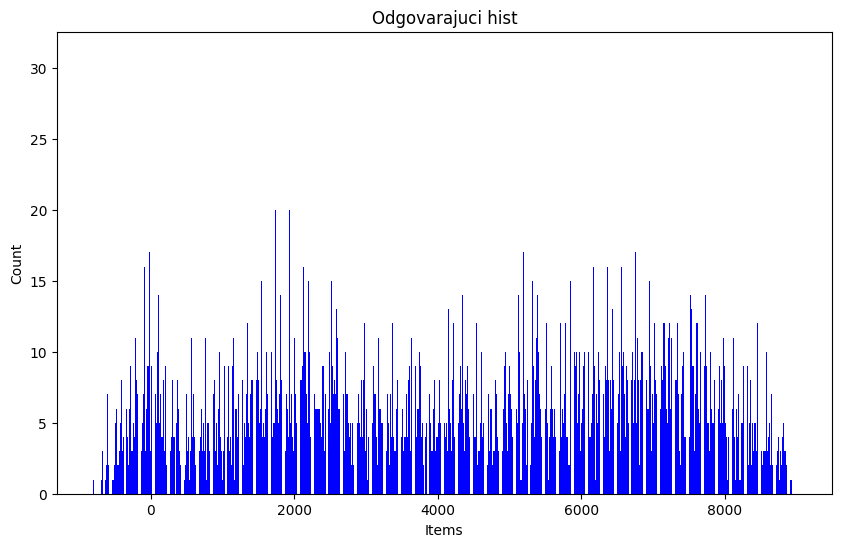

[(865, 3), (1370, 3), (1285, 3)]


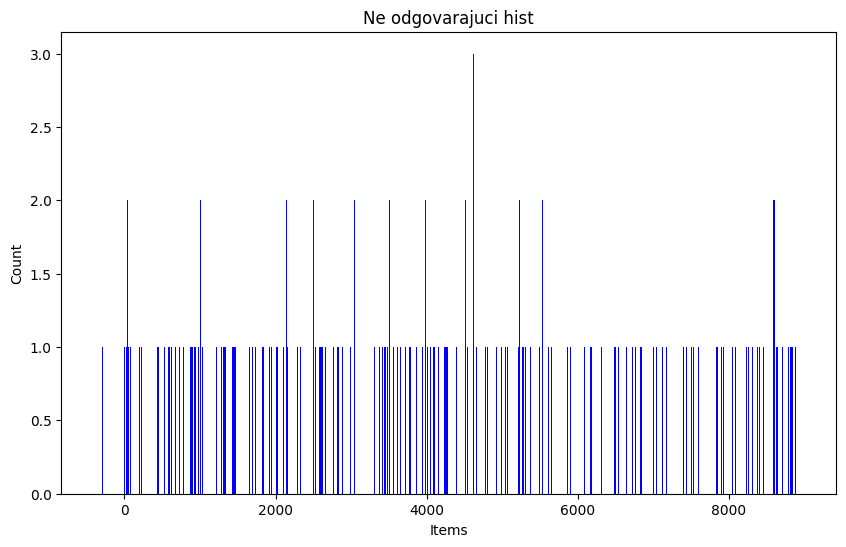

In [19]:
test_fingerprinting(original, positive_test, negative_test, find_maxims, args_find_maxims)

In [21]:
data = json.load(open("fingerprinting_local_maximum.json", "r"))
tolerance = tolerance_maximum
args = args_local_maximum
f = find_local_maxima

In [22]:
lock = threading.Lock()
def predict(filename, f, args):
    with lock:
        original, original_sr = librosa.load(filename)
        original = np.abs(librosa.stft(original))
        print("STARTED PREDICTION")
        y_cords, x_cords = f(original, *args)
        most_similar = 0
        best_song = ""
        for song, values in data.items():
            similarity = evaluate_similarity(values['x'], values['y'], x_cords, y_cords, *tolerance)
            if similarity > most_similar:
                best_song = song
                most_similar = similarity

        print(f"Best match: {best_song} with similarity: {most_similar}")
        return best_song

def save_as_mp3(frames, sample_rate, channels, filename):
    # Convert raw audio data to AudioSegment
    audio_data = np.hstack(frames).astype(np.int16)
    audio_segment = AudioSegment(
        data=audio_data.tobytes(),
        sample_width=audio_data.dtype.itemsize,
        frame_rate=sample_rate,
        channels=channels
    )
    # Export as MP3
    audio_segment.export(filename, format="mp3")
    print(f"Saved {filename}")
    predict(filename, f, args)

def record_audio(duration=10, sample_rate=44100, chunk=1024):
    format = pyaudio.paInt16  # 16 bits per sample
    channels = 1  # Mono

    # Create an instance of PyAudio
    p = pyaudio.PyAudio()

    # Open a stream for recording
    stream = p.open(format=format,
                    channels=channels,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=chunk)

    print("Recording started")

    def record_and_save():
        file_index = 1
        while True:
            frames = []
            for _ in range(0, int(sample_rate / chunk * duration)):
                data = stream.read(chunk)
                frames.append(np.frombuffer(data, dtype=np.int16))

            # Save the recorded data as an MP3 file
            filename = f"recording_{file_index}.mp3"
            save_as_mp3(frames, sample_rate, channels, filename)

            # Wait for prediction to complete before continuing
            with lock:
                file_index += 1

    # Create and start a new thread to handle recording and saving
    thread = threading.Thread(target=record_and_save)
    thread.daemon = True
    thread.start()

    # Keep recording until stopped
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("Recording stopped")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()

    # Terminate the PyAudio object
    p.terminate()

# Example usage
record_audio()

Recording started
Saved recording_1.mp3
STARTED PREDICTION
Best match: Koktel ljubavi (320K).mp3 with similarity: 7
Saved recording_2.mp3
STARTED PREDICTION
Best match: Anastasija - Rane - (Official Video 2019).mp3 with similarity: 5
Saved recording_3.mp3
STARTED PREDICTION
Best match: Bane Bojanic - Samo pijan mogu da prebolim - (Audio 2001) (320K).mp3 with similarity: 5
Saved recording_4.mp3
STARTED PREDICTION
Best match: Tose Proeski - Boze,brani je od zla.mp3 with similarity: 7
Saved recording_5.mp3
STARTED PREDICTION
Best match: Bajaga i Instruktori - Vesela pesma - (Audio 1988) (320K).mp3 with similarity: 6
Saved recording_6.mp3
STARTED PREDICTION
Best match: Uzbuna (320K).mp3 with similarity: 7
Recording stopped


: 